# Epidemiological modelling of spread of COVID-19 GUI

### Import Modules

In [85]:
!pip install mpld3
import mpld3
import io
%matplotlib inline 
import numpy as np
import pandas as pd
import math
from pandas import DataFrame
import seaborn as sb
%matplotlib inline
mpld3.enable_notebook()
import plotly.express as px
from google.colab import files
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.integrate import odeint
from scipy.optimize import minimize

### Functions required for the modelling

SEIRD Lockdown

Change of equations for the SEIRD model to factor in phase based change in contact rate for a country

In [0]:
def SEIRD_lockdown(y, t, l1, l2, l3, gamma, delta, mu):
    if t < L1:
        beta = l1 * gamma
    elif t < L2:
        beta = l2 * gamma
    else:
        beta = l3 * gamma
    S, E, I, R, D = y
    dSdt = -beta * S * I / N + gamma * I
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

Integrating the SEIRD lockdown model

Integrating the SEIRD lockdown model over time period t specified

In [0]:
### SEIRD Lockdown model loss
# Integrate the SEIRD equations over the time grid, t.
def SEIRD_integrate_lockdown(initial, t, params):
    # initial = (S0, E0, I0, R0, D0)
    # params = beta, delta, gamma, mu

    t = list(range(t)) # creates a list of time points with length t
    l1, l2, l3, gamma, delta, mu = params
    result = odeint(SEIRD_lockdown, initial, t, args=(l1, l2, l3, gamma, delta, mu))
    return result

Save Dataframe

Function to save the imported data of countries to data frame

In [0]:
def get_dataframe(result):
    result = pd.DataFrame(result, columns = ['S', 'E', 'I', 'R', 'D'])
    time_points = list(range(len(result)))
    result.insert(0, 'days', time_points, True)
    return result

Model loss for lockdown SEIRD uploaded data

Function to calculate squared error loss between predicted and actual data taking into account the three phase model for uploaded data

In [0]:
def model_loss_lockdown_up(params):
    r = 0 # residual
    for t in range(1, len(data_df) + 1):
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 2] - data_df['total_cases'][t - 1]) ** 2
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 3] - data_df['total_recovered'][t - 1]) ** 2
        r += (SEIRD_integrate_lockdown(y0, t, params)[t - 1, 4] - data_df['total_dead'][t - 1]) ** 2
    return math.sqrt(r) 

Function to parameterize for machine learning model

In [0]:
def parametrize(params):
  params = minimize(model_loss_lockdown_up, 
                    x0 = params, 
                    method = 'TNC',
                    bounds = ((3, 50), (1, 20), (0.2, 0.9), (1e-6, 0.5), (1e-6, 0.5), (1e-6, 0.5))).x
  return params

Input data processing

In [0]:
class analyze_input:
    
    def __init__(self, N, region_name, region_data, upload_name):
        self.N = N
        self.region_name = region_name
        self.region_data = region_data
        self.upload_name = upload_name

    def read_input(self):
        region_data = self.region_data
        upload_name = self.upload_name
        data_df_d = pd.read_csv(io.StringIO(region_data[upload_name].decode('utf-8')))
        data_df = data_df_d[data_df_d['total_cases'] > 99]  
        data_df.insert(0, 'days', list(range(len(data_df))), True)
        data_df = data_df.reset_index()
        self.data_df = data_df
        return data_df

    def visualise_input(self):
        fig = go.Figure()
        data_df = self.data_df
        fig.add_trace(go.Scatter(x=data_df['days'] , y=data_df['total_cases'], name = 'Infected',line=dict(color='blue', width=4)))
        fig.add_trace(go.Scatter(x=data_df['days'] , y=data_df['total_recovered'], name='Recovered',line=dict(color='green', width=4)))
        fig.add_trace(go.Scatter(x=data_df['days'] , y=data_df['total_dead'], name='Fatalities',line=dict(color='red', width=4)))
        reg_title = self.region_name + ": Actual Data"
        fig.update_layout(title=reg_title,
                        xaxis_title='Days since 100th case',
                        yaxis_title='Number of cases',
                        legend_orientation="h")
        return fig
        
    def analyze_parameters_manual(self):
        N = self.N
        hmap_list = []
        for i in range (1, 20, 4):
            for j in range(1, 10, 3):
                for k in range(1, 20, 4):
                    for l in range(1, 20, 4):
                        for m in range(0, 7):
                            for n in range(10,40,10):
                                h1 = []
                                l1 = i
                                l2 = j
                                l3 = 1
                                L1 = n
                                L2 = n + 10
                                g0 = 1.0 / k
                                d0 = 1.0 / l
                                m0 = 1.0 * 10.0 ** (-m)
                                y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
                                d = model_loss_lockdown_up((l1, l2, l3, g0, d0, m0))
                                h1 = [l1, l2, l3, L1, L2, g0, d0, m0, d]
                                print(h1)
                                hmap_list.append(h1)
        data_params_df = pd.DataFrame(hmap_list)
        data_params_df.to_csv("data_params.csv")
        data_params_df = pd.read_csv("data_params.csv", header=0)
        minIndex = data_params_df['8'].idxmin()
        a = data_params_df.iloc[minIndex]
        print("Population size = " + str(pop_no) + "\nReproductive number for phase 1 = " + str(a[1]) + "\nReproductive number for phase 2 = " + str(a[2]) + "\nReproductive number for phase 3 = " + str(a[3]) + "\nStart day for phase 2 = " + str(a[4]) + "\nStart day for phase 3 = " + str(a[5]) + "\nRecovery rate = " + str(a[6]) + "\nDelta = " + str(a[7]) + "\nMortality rate = " + str(a[8]))     
        self.manual_params = (a[1], a[2], a[3], a[6], a[7], a[8])
        return (a[1], a[2], a[3], a[6], a[7], a[8]), a[4], a[5]

    def analyze_parameters_ml(self):
        N = self.N
        mod_loss = 100000000
        op_l1 = 0
        op_l2 = 0
        for m in range(10,40,10):
            for n in range(10,40,10):
                L1 = m
                L2 = n
                params_ma = self.manual_params
                ml_upload = parametrize(params_ma)
                lo = model_loss_lockdown_up(ml_upload)
                if (lo < mod_loss):
                    mod_loss = lo
                    params = ml_upload
                    op_l1 = L1
                    op_l2 = L2
        print("Population size = " + str(N) + "\nReproductive number for phase 1 = " + str(params[0]) + "\nReproductive number for phase 2 = " + str(params[1]) + "\nReproductive number for phase 3 = " + str(params[2]) + "\nStart day for phase 2 = " + str(op_l1) + "\nStart day for phase 3 = " + str(op_l2) + "\nRecovery rate = " + str(params[3]) + "\nDelta = " + str(params[4]) + "\nMortality rate = " + str(params[5]))
        return params, op_l1, op_l2

    def R0_heatmap(self):
        data_params_df = pd.read_csv("data_params.csv", usecols = ['0', '1', '8'], header=0)
        data_params_df = data_params_df[data_params_df['8'] == data_params_df.groupby(['0', '1'])['8'].transform('min')] 
        heatmap1_data = pd.pivot_table(data_params_df, values='8', 
                            index=['1'], 
                            columns='0')
        b = sb.heatmap(heatmap1_data)
        plt.xlabel("R0 value before lockdown")
        plt.ylabel("R0 value post-lockdown, social distancing/mask usage")
        plt.show()

    def mortality_recovery_heatmap(self):
        data_params_df = pd.read_csv("data_params.csv", usecols = ['5', '7', '8'], header=0)
        data_params_df = data_params_df[data_params_df['8'] == data_params_df.groupby(['5', '7'])['8'].transform('min')] 
        heatmap1_data = pd.pivot_table(data_params_df, values='8', 
                            index=['7'], 
                            columns='5')
        heatmap1_data = np.log(heatmap1_data)
        sb.heatmap(heatmap1_data)
        plt.ylabel("Mortality rate")
        plt.xlabel("Recovery rate")
        plt.show()

    def actual_predicted(self, L1, L2, params):
        L1 = L1
        L2 = L2
        data_df = self.data_df
        ret2 = SEIRD_integrate_lockdown(y0, 70, params)
        S, E, I, R, D = ret2.T
        pred_up2 = get_dataframe(ret2)
        pred_up2.head()
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=data_df['days'] , y=data_df['total_cases'], name = 'Infected',line=dict(color='blue', width=4)))
        fig.add_trace(go.Scatter(x=data_df['days'] , y=data_df['total_recovered'], name='Recovered',line=dict(color='green', width=4)))
        fig.add_trace(go.Scatter(x=data_df['days'] , y=data_df['total_dead'], name='Fatalities',line=dict(color='red', width=4)))

        fig.add_trace(go.Scatter(x=pred_up2['days'] , y=pred_up2['I'], name = 'Predicted Infected',line=dict(color='blue', width=4, dash='dot')))
        fig.add_trace(go.Scatter(x=pred_up2['days'] , y=pred_up2['R'], name='Predicted Recovered',line=dict(color='green', width=4, dash='dot')))
        fig.add_trace(go.Scatter(x=pred_up2['days'] , y=pred_up2['D'], name='Predicted Fatalities',line=dict(color='red', width=4, dash='dot')))
        reg_title = self.region_name + ": Cases plot"
        fig.update_layout(title=reg_title,
                        xaxis_title='Days since 100th case',
                        yaxis_title='Number of cases',
                        legend_orientation="h")
        return fig

## GUI 

This part of the notebook will allow you to model the spread of COVID-19 for any region specified.

The model used here is an SEIRD lockdown model which models the spread in three phases for the region specified. The spread will be parameterised to minimise loss between actual data and the modelling done.

The only input required from the user is the initial population size and the data about the spread of the disease(having information about total recovered, total dead and total cases day wise)

In [92]:
reg = input("Enter region name: ") 

Enter region name: Korea


In [93]:
pop_no = int(input("Enter the initial population number(without commas): "))

Enter the initial population number(without commas): 54932765


Upload data for the region specified(preferably a csv file with columns: day_count, total_cases, total_dead, total_recovered)

In [94]:
upload_name = input("Enter name of file being uploaded: ") 

Enter name of file being uploaded: KOR_data2.csv


In [72]:
region_data = files.upload()

Saving KOR_data2.csv to KOR_data2 (1).csv


Visualisation of input data

In [107]:
up_data = analyze_input(pop_no, reg, region_data, upload_name)
data_df = up_data.read_input()
up_data.visualise_input()

Analysing input data using SEIRD Lockdown model

In [108]:
params1, L1, L2 = up_data.analyze_parameters_manual()
N = pop_no
y0 = N-100, 10, 100, 0, 0 # Initial conditions vector, 100 cases and 1 exposed
params, op_l1, op_l2 = up_data.analyze_parameters_ml()

Streaming output truncated to the last 5000 lines.
[5, 7, 1, 30, 40, 0.1111111111111111, 0.1111111111111111, 1e-05, 54250.13765215474]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.1111111111111111, 1e-06, 54247.99738016902]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.1111111111111111, 1e-06, 54247.99738016902]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.1111111111111111, 1e-06, 54247.99738016902]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.07692307692307693, 1.0, 77121.80880767704]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.07692307692307693, 1.0, 77121.80880767704]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.07692307692307693, 1.0, 77121.80880767704]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.07692307692307693, 0.1, 73849.18826525936]
[5, 7, 1, 20, 30, 0.1111111111111111, 0.07692307692307693, 0.1, 73849.18826525936]
[5, 7, 1, 30, 40, 0.1111111111111111, 0.07692307692307693, 0.1, 73849.18826525936]
[5, 7, 1, 10, 20, 0.1111111111111111, 0.07692307692307693, 0.01, 64724.71854754743]
[5, 7, 1, 20, 30, 0.11111111111

Visualisation of the parameter fitting for the region 

TypeError: ignored

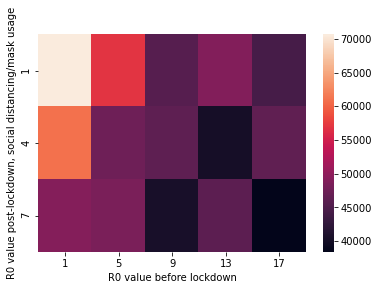

In [109]:
up_data.R0_heatmap()

TypeError: ignored

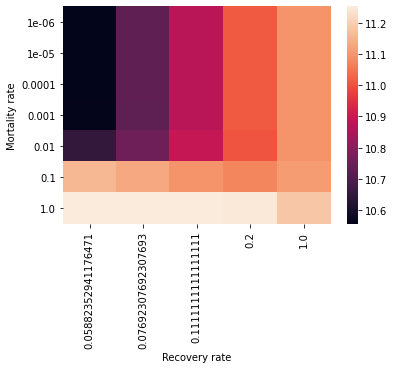

In [110]:
up_data.mortality_recovery_heatmap()

Actual data vs modelling prediction for region

In [111]:
up_data.actual_predicted(L1, L2, params)